In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

### [Zachary's Karate Club](https://en.wikipedia.org/wiki/Zachary's_karate_club) Dataset

In [2]:
from torch_geometric.datasets import KarateClub

edge_index = KarateClub().get(0).edge_index

# add batch coordinate to edge index
coords = torch.concat([
    torch.zeros([1, edge_index.shape[-1]], dtype=int),
    edge_index
])

# construct sparse adjacency matrix from coordinates
data = torch.sparse_coo_tensor(
    indices = coords,
    values = torch.ones(coords.shape[-1]),
    size = [1, 34, 34]
)

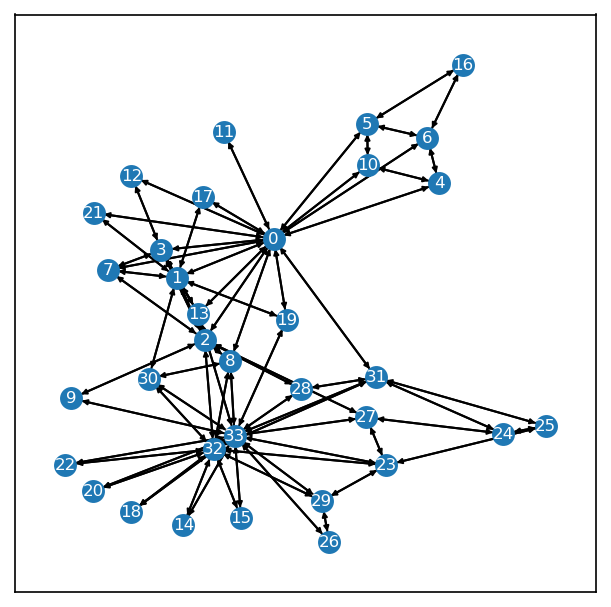

In [3]:
G = to_networkx(Data(edge_index=edge_index, num_nodes=34))
fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=150)
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42),

    with_labels=True,
    font_size=8,
    font_color='white',
    
    arrows=True,
    arrowsize=5,
    node_size=100,

    ax=ax,
)

### fastRG graph sampling (https://arxiv.org/pdf/1703.02998.pdf)
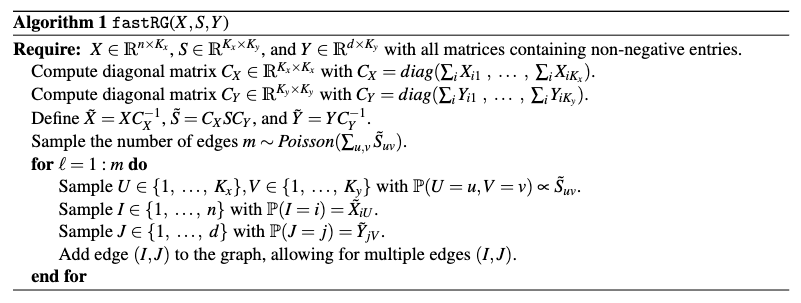

In [ ]:
class SBM(dist.TorchDistribution):
    def __init__(self, X, S, Y=None):
        
        # source node membership matrices
        self.X = X
        self.n_batches, self.n_nodes, self.n_blocks = X.shape

        super().__init__(
            batch_shape = torch.Size([self.n_batches]),
            event_shape = torch.Size([self.n_nodes, self.n_nodes]),
            validate_args=False
        )
        
        # block connection probabilities
        self.S = S
        assert S.shape == self.batch_shape + torch.Size([self.n_blocks, self.n_blocks])
        
        # sink node membership matrix (same as X by default)
        if Y is not None:
            self.Y = Y
        else:
            self.Y = X
            
        # log expectation matrices
        self.log_expectation = torch.matmul(X, torch.matmul(S, X.transpose(-1,-2))).log()
            
        # membership count matrices
        CX = torch.stack(
            tuple(map(torch.diag, self.X.sum(1)))
        )
        CY = torch.stack(
            tuple(map(torch.diag, self.Y.sum(1)))
        )
        
        # membership probabilitites
        self.Xtilde = torch.matmul(self.X, torch.inverse(CX))
        self.Ytilde = torch.matmul(self.Y, torch.inverse(CY))
                
        # block degree matrix
        self.Stilde = torch.matmul(CX, torch.matmul(S, CY))
        
        # distributions
        self.num_edge_dist = dist.Poisson(self.Stilde.sum([1,2]))
        self.block_dist = dist.Multinomial(probs=self.Stilde.flatten(1))
        
        
    def sample(self, sample_shape=torch.Size()):
        
        sample_shape = torch.Size(sample_shape)
        assert len(sample_shape) in [0, 1], "only 0D or 1D sampling supported"

        # number of edges per sample
        num_edges = self.num_edge_dist.sample(sample_shape).int()
        
        if len(sample_shape) == 0:
            num_edges = num_edges.unsqueeze(0)
        
        tot_edges_per_batch = num_edges.sum(0)
        max_edges_per_batch = tot_edges_per_batch.max()
        
        # sample block selections for each edge
        blocks = self.block_dist.sample(max_edges_per_batch.unsqueeze(0))
        
        # create block selection matrices
        blocks = blocks.reshape(
            torch.Size([max_edges_per_batch]) +
            self.batch_shape +
            torch.Size([self.n_blocks]*2)
        )
        
        # select node probabilities for each edge
        source_probs = torch.matmul(self.Xtilde, blocks).sum(-1)
        sink_probs = torch.matmul(blocks, self.Ytilde.transpose(-1, -2)).sum(-2)
                
        # sample node selections for each edge
        sources = dist.Categorical(source_probs).sample()
        sinks = dist.Categorical(sink_probs).sample()
        
        # construct edge lists for each sample and batch
        coords = []
        for batch_coo in range(self.batch_shape.numel()):
            
            tot_edges = tot_edges_per_batch[batch_coo]
            n_edges = num_edges[:, batch_coo]
            
            # slice out edges for this batch
            edges = torch.stack([
                sources[:tot_edges, batch_coo],
                sinks[:tot_edges, batch_coo]
            ])
            
            # split edges into samples
            edge_lists = torch.split(edges, tuple(n_edges), -1)
            
            # construct 4-D (sample, batch, source, sink) coordinates
            for sample_coo, edge_list in enumerate(edge_lists):
                n = edge_list.shape[-1]
                coords.append(
                    torch.concat([
                        torch.Tensor([sample_coo]).int().expand([1, n]),
                        torch.Tensor([batch_coo]).int().expand([1, n]),
                        edge_list
                    ])
                )
                
        coords = torch.concat(coords, -1)
        
        # remove sample coordinate if not in use
        if len(sample_shape) == 0:
            coords = coords[1:, :]
        
        # construct (n_samples * n_batches) sparse (n_nodes * n_nodes) adjacency matrices
        return torch.sparse_coo_tensor(
            indices = coords,
            values = torch.ones(coords.shape[-1]),
            size = self.shape(sample_shape)
        )

    def log_prob(self, x):
        
        # check shapes
        assert len(x.shape) in [3, 4], "invalid tensor shape. x must be 3D or 4D"
        
        if len(x.shape) == 4:
            n_samples, n_batches, n_i, n_j = x.shape
        elif len(x.shape) == 3:
            n_batches, n_i, n_j = x.shape
            n_samples = 1
            
        assert n_batches == self.batch_shape.numel(), "x does not match distribution batch shape"
        assert n_i == self.n_nodes and n_j == self.n_nodes, "x does not match distribution event shape"
            
        # assume sparse x
        assert x.layout == torch.sparse_coo, "x must be a sparse coordinate tensor"
        
        # sort coordinates
        if not x.is_coalesced():
            x = x.coalesce()
        
        coords = x.indices()
        
        # add coordintate for single sample
        if len(x.shape) == 3:
            coords = torch.concat([
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords
            ])
        
        # compute scores
        scores = torch.zeros([n_samples, n_batches])
        for sample_coo, batch_coo, source, sink in coords.T:
            scores[sample_coo, batch_coo] += self.log_expectation[batch_coo, source, sink]
        
        # remove coordinate for single sample
        if len(x.shape) == 3:
            scores = scores[0, :]
        
        return scores
            

### Pyro Modeling

In [ ]:
def model(edges=None):
    # start with maximum-likelihood estimation (fixed parameters)
    X = pyro.param("X", lambda: torch.Tensor([0.5, 0.5]).expand([1, 34, 2]), constraint=constraints.positive)
    S = pyro.param("S", lambda: torch.Tensor([[0.5, 0.5], [0.5, 0.5]]), constraint=constraints.positive)
    
    return pyro.sample("obs", SBM(X, S), obs=edges)

def guide(edges=None):
    # todo
    pass